# Coding Temple's Data Analytics Program:
---
## Python for DA: Machine Learning Assignment

For your assignment today, you will look through the [UCI Irvine ML Repository](https://archive.ics.uci.edu/datasets) to find a dataset that you can build a model on. Your workflow should look something like:

- Import any necessary libraries
- Load in the data
- Clean/Tidy the Data
- Explore the data:
    - Gather all summary statistics
    - Visualize your data and your target
    - Identify any relationships between your target and the feature matrix
    - Loop back through and continue cleaning data/feature engineering as needed
- Split the data
- Establish a baseline model
- Create model
- Establish model accuracy
- Hypertune your model
- Communicate your results

The model, data, and methods you use are all completely up to you for this assignment! Ensure you label your notebook with markdown cells and proper comments

Import Libraries

First I imported the necessary libraries, read in the data set, and named it.

In [2]:
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, roc_auc_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier, XGBRegressor


import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [3]:
data = pd.read_csv('/Users/lisatosti/Documents/GitHub/coding-temple/week 4/assignments/ml assignment and data/heart_failure_clinical_records_dataset.csv')
data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


Check shape of data to see how many rows and columns I will be working with

In [4]:
data.shape

(299, 13)

Determine if there are null values and if they need to be dropped.

In [5]:
data.isnull().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

This dataframe does not have any null values.

I then wanted to look at the data types.

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


Since all data types are numeric, I wanted to take a look at the correclations of clinical findings for patients with heart failure.

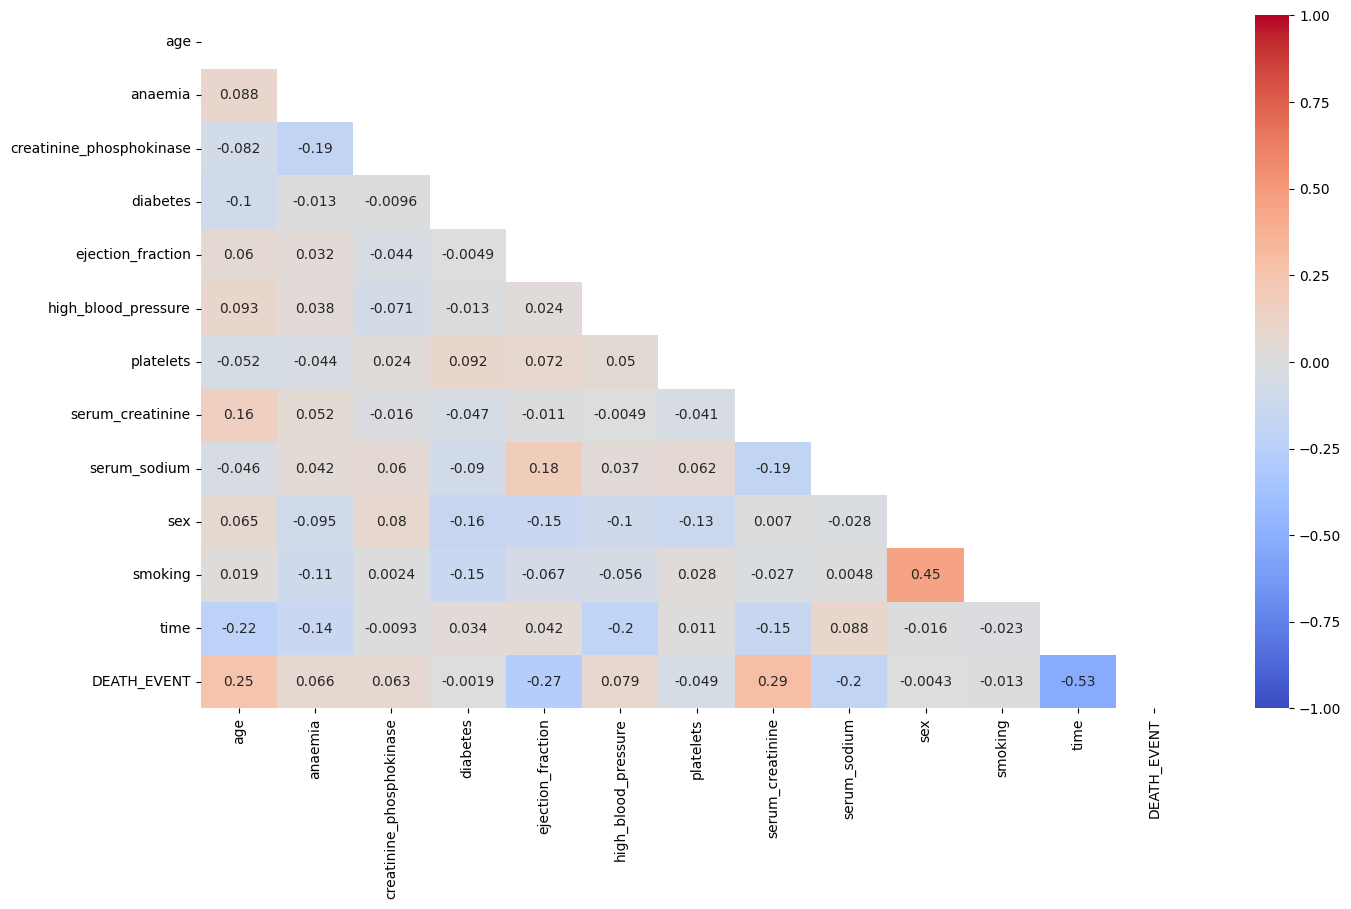

In [7]:
#Create correlation of variables in dataframe
corr = data.corr()

#Create a heatmap to showcase the correlations with the dataframe

#Set the size of figure
plt.figure(figsize= (16,9))

#Mask the upper triangle to reduce duplicate correlations
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

#Plot correlation heatmap
sns.heatmap(corr,
            mask = mask,
            cmap= 'coolwarm',
            annot=True,
            vmax= 1,
            vmin= -1);



The highest correclation is between smoking and sex, while the lowest correlation of time and DEATH_EVENT. Based on the documentation for the dataset, time refers to the number of days in the follow-up period. DEATH_EVENT signifies if the patient died during the follow up period. This most likely indicates that the longer(increase) the time between incident and follow up, the decrease in the patient's mortality.

Looking at clinical information that is related specifically to lab results, serum_creatinine seems to have the next highest correlation with DEATH_EVENT. This will be a good option to consider for machine learning to see if we can predict a patient's mortality based on their serum_creatine.

Let's start looking at how serum_creatinine's relationship to the DEATH_EVENT.

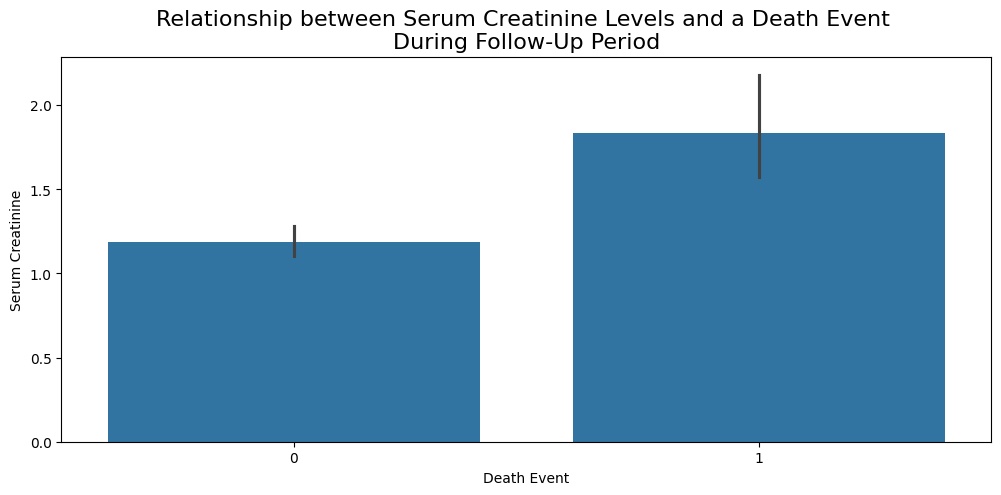

In [8]:
plt.figure(figsize = (12, 5))

# Barplot
sns.barplot(y = data['serum_creatinine'], x = data['DEATH_EVENT'])

# Create a descriptive title
plt.title('Relationship between Serum Creatinine Levels and a Death Event \nDuring Follow-Up Period', fontsize = 16)

# Add axis labels
plt.xlabel('Death Event')
plt.ylabel('Serum Creatinine');

The 1 for the Death Event indicates that the patient's died during the follow-up period. Higher Serum Creatinine does seem to be a strong indicator for a death event and could save many lives but monitoring closely during the follow-up period to initiate intervention when necessary.

Since the DEATH_EVENT is what we are hoping to predict based on our other data, this is what we will be using as our target for our machine learning. 

In [9]:
#Setting DEATH_EVENT as target
target = 'DEATH_EVENT'

X = data.drop(columns=[target])
y = data[target]

#Spliting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2, random_state=42, stratify=y)
assert len(X_train) + len(X_test) == len(X), 'You done messed up, A A Ron!'


In [10]:
#test y_train
y_train

115    0
23     0
0      1
247    0
194    1
      ..
229    0
131    0
177    0
112    0
28     1
Name: DEATH_EVENT, Length: 239, dtype: int64

Now we will set our baseline for serum creatinine based on the mean.

In [11]:
#baseline for classification
print(data['DEATH_EVENT'].value_counts(normalize=True))
print('--------------')
print(y_train.value_counts(normalize=True))
print('--------------')
print(y_test.value_counts(normalize=True))


DEATH_EVENT
0    0.67893
1    0.32107
Name: proportion, dtype: float64
--------------
DEATH_EVENT
0    0.677824
1    0.322176
Name: proportion, dtype: float64
--------------
DEATH_EVENT
0    0.683333
1    0.316667
Name: proportion, dtype: float64


Set Baseline score

In [12]:
baseline = (data['DEATH_EVENT'].value_counts(normalize=True) * 100).round(2)

baseline

DEATH_EVENT
0    67.89
1    32.11
Name: proportion, dtype: float64

The baseline accuracy is set at 67.89%. 

Since the data set does not have string values, there is no need to convert any data types.
I will instantiate my mode using Logistic Regression as it is a Classification dataframe.

Each model (Logistic Regression, Decision Tree Classifier, Random Forest Classifier, ) will be fitted on the training set.

In [13]:
logreg = LogisticRegression(random_state=42, solver='liblinear')

logreg.fit(X_train, y_train)

LogisticRegression(random_state=42, solver='liblinear')

In [14]:
dt = DecisionTreeClassifier(random_state=42)

dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [15]:
rf = RandomForestClassifier(random_state=42)

rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [16]:
xg = XGBClassifier()

xg.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be 

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Check the train and test scores.

In [17]:
print('Logistic Regression:')
print(f"The training score is: {(logreg.score(X_train, y_train) * 100).round(2)}")
print(f"The test score is: {(logreg.score(X_test, y_test) * 100).round(2)}")
print('---------------------------')

print('Decision Tree Classifier:')
print(f"The training score is: {(dt.score(X_train, y_train) * 100).round(2)}")
print(f"The test score is: {(dt.score(X_test, y_test) * 100).round(2)}")
print('---------------------------')

print('Random Forest Classifier:')
print(f"The training score is: {(rf.score(X_train, y_train) * 100).round(2)}")
print(f"The test score is: {(rf.score(X_test, y_test) * 100).round(2)}")
print('---------------------------')

print('XGBClassifier:')
print(f"The training score is: {(xg.score(X_train, y_train) * 100).round(2)}")
print(f"The test score is: {(xg.score(X_test, y_test) * 100).round(2)}")


Logistic Regression:
The training score is: 83.26
The test score is: 81.67
---------------------------
Decision Tree Classifier:
The training score is: 100.0
The test score is: 73.33
---------------------------
Random Forest Classifier:
The training score is: 100.0
The test score is: 83.33
---------------------------
XGBClassifier:
The training score is: 100.0
The test score is: 83.33


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be 

Check Metric Accuracy

In [18]:
logreg.predict(X_test)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0])

In [19]:
logreg.predict_proba(X_test).round(2)

array([[0.97, 0.03],
       [0.6 , 0.4 ],
       [0.81, 0.19],
       [0.93, 0.07],
       [0.84, 0.16],
       [1.  , 0.  ],
       [0.84, 0.16],
       [0.74, 0.26],
       [0.99, 0.01],
       [0.85, 0.15],
       [0.94, 0.06],
       [0.29, 0.71],
       [0.58, 0.42],
       [0.97, 0.03],
       [0.81, 0.19],
       [0.47, 0.53],
       [0.54, 0.46],
       [0.14, 0.86],
       [0.99, 0.01],
       [0.97, 0.03],
       [0.79, 0.21],
       [0.98, 0.02],
       [0.63, 0.37],
       [1.  , 0.  ],
       [0.99, 0.01],
       [0.68, 0.32],
       [0.97, 0.03],
       [0.21, 0.79],
       [0.85, 0.15],
       [0.56, 0.44],
       [0.86, 0.14],
       [0.95, 0.05],
       [0.99, 0.01],
       [0.29, 0.71],
       [0.68, 0.32],
       [0.13, 0.87],
       [0.36, 0.64],
       [0.33, 0.67],
       [0.3 , 0.7 ],
       [0.15, 0.85],
       [0.93, 0.07],
       [0.96, 0.04],
       [0.98, 0.02],
       [0.94, 0.06],
       [0.96, 0.04],
       [0.99, 0.01],
       [0.97, 0.03],
       [0.55,

In [29]:
print('Logistic Regression:')
print(f'Training Accuracy: {roc_auc_score(y_train, logreg.predict(X_train)) * 100}')
print(f'Testing Accuracy: {roc_auc_score(y_test, logreg.predict(X_test)) * 100}')
print("------------------")
print('Decision Tree Classifier:')
print(f'Training Accuracy: {roc_auc_score(y_train, dt.predict(X_train)) * 100}')
print(f'Testing Accuracy: {roc_auc_score(y_test, dt.predict(X_test)) * 100}')
print('Random Forest Classifier:')
print(f'Training Accuracy: {roc_auc_score(y_train, rf.predict(X_train)) * 100}')
print(f'Testing Accuracy: {roc_auc_score(y_test,rf.predict(X_test)) * 100}')
print("------------------")
print('XGBoost Classifier:')
print(f'Training Accuracy: {roc_auc_score(y_train, xg.predict(X_train)) * 100}')
print(f'Testing Accuracy: {roc_auc_score(y_test, xg.predict(X_test)) * 100}')
print("------------------")

Logistic Regression:
Training Accuracy: 79.47731281064614
Testing Accuracy: 73.8767650834403
------------------
Decision Tree Classifier:
Training Accuracy: 100.0
Testing Accuracy: 66.36713735558408
Random Forest Classifier:
Training Accuracy: 100.0
Testing Accuracy: 77.92041078305519
------------------
XGBoost Classifier:
Training Accuracy: 100.0
Testing Accuracy: 76.50834403080873
------------------


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be 

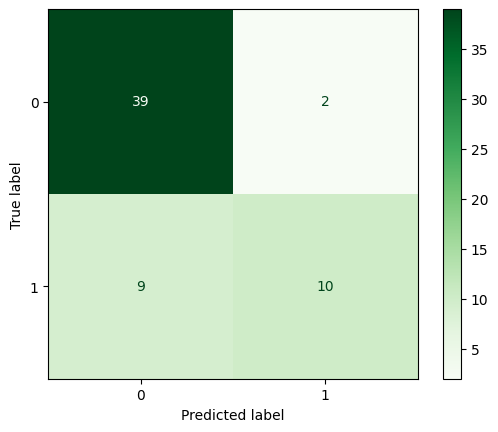

In [20]:
ConfusionMatrixDisplay.from_predictions(y_pred= logreg.predict(X_test),y_true= y_test, cmap='Greens');

The fact that there are false positives could point to the fact that while these patient's are likely to survive based on our model, our patient's do not live inside a vacuum. There could be other factors outside of our clinical data that could affect a patient's mortality.

In [28]:
pd.Series(np.exp(logreg.coef_[0]), index= X.columns)

age                         1.027820
anaemia                     1.000452
creatinine_phosphokinase    1.000249
diabetes                    1.000683
ejection_fraction           0.955655
high_blood_pressure         1.000160
platelets                   0.999999
serum_creatinine            1.005898
serum_sodium                1.013252
sex                         0.999754
smoking                     0.999951
time                        0.978535
dtype: float64

Let's look at the serum_creatinine coefficient.

In [22]:
np.exp(0.005881)

1.0058983270306026

An increase in serum_creatinine suggests the patient is 1 times more likely to experience a death event.

Let's also look at time coefficient.

In [23]:
np.exp(-0.021699)


0.9785347296811788

A 1 unit increase in the time (days) variable suggests that the patient is 2.2% less likely to experience a death event.

Recommendations based on predictive model
-----------------------------------------

Monitoring of a patient's serum creatinine can be utilized for early intervention to decrease patient's likelihood of a death event.

More days(time) between heart failure and follow-up increase the patient's likelihood of survival. However, if we look at the coefficient for age, we can also see that a patient's likelihood to experience a death event increases 1.03 times. So while as more time elapses, as patient's survial rate increases, this may only be in the short term as with every passing year, their likelihood of a death event increases.